# Panagiotis Karamitopoulos
# Assignment 7 - SVM - Bayes

# Import Libraries

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Question 1

# 1.1 Load Dataset


In [2]:
df = pd.read_csv('train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# 1.2 Create Input and Target Variables


In [3]:
x = df.drop(columns=['target'])
y = df['target']
x.shape, y.shape


((7613, 4), (7613,))

#1.3 Split Dataset to Train-Test

In [4]:
seed = 0
test_size = 0.1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed, stratify=y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6851, 4), (6851,), (762, 4), (762,))

#1.4 Plot Target

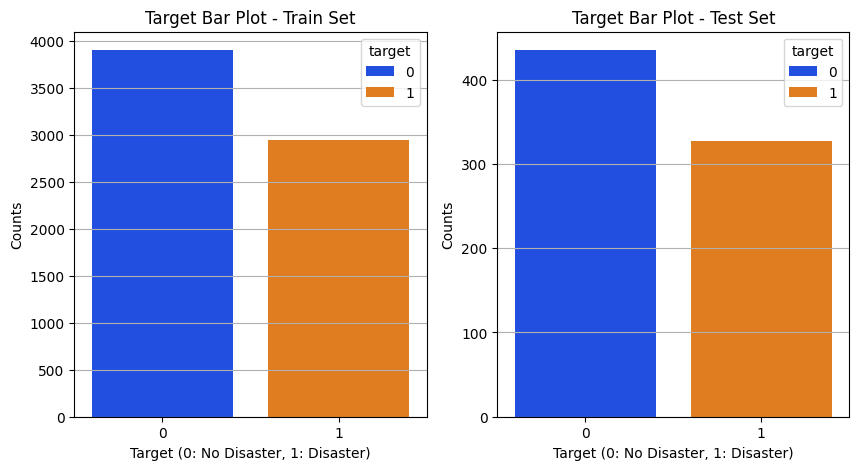

In [5]:
y_sets = [y_train, y_test]
set_names = ['Train', 'Test']
plt.figure(figsize=(10, 5))
for i in range(len(y_sets)):
    plt.subplot(1, 2, i + 1)
    sns.countplot(x=y_sets[i], hue=y_sets[i], palette='bright')
    plt.title(f'Target Bar Plot - {set_names[i]} Set')
    plt.xlabel('Target (0: No Disaster, 1: Disaster)')
    plt.ylabel('Counts')
    plt.grid(axis='y')
plt.show()

Από τα παραπάνω bar plots με το πλήθος των target στα train και test sets προκύπτει ότι ο αριθμός των αναρτήσεων που σηματοδοτούν φυσική καταστροφή (target: 1) είναι μικρότερος από τον αριθμό των αναρτήσεων που δεν σηματοδοτούν καταστροφή (target: 0). Πιο συγκεκριμένα, στο train set υπάρχουν 3000 αναρτήσεις περίπου που αντιστοιχούν σε φυσική καταστροφή (target: 1) και 4000 αναρτήσεις περίπου που δεν αντιστοιχούν σε φυσική καταστροφή (target: 0). Αντίστοιχα, λόγω της stratify=y η ίδια αναλογία διατηρείται και στο test set, όπου υπάρχουν περίπου 320 αναρτήσεις που αντιστοιχούν σε φυσική καταστροφή και 430 αναρτήσεις περίπου που δεν αντιστοιχούν σε φυσική καταστροφή. Συνεπώς, το dataset είναι ελαφρώς μη ισορροπημένο.

# Question 2

#2.1 Drop ID, Location

In [6]:
x_train = x_train.drop(columns=['id', 'location'])
x_test = x_test.drop(columns=['id', 'location'])
x_train.shape, x_test.shape

((6851, 2), (762, 2))

#2.2 Missing Data Imputation

In [7]:
missing_values = x_train.isnull().sum()
missing_values

,0
keyword,54
text,0


In [8]:
missing_values = x_test.isnull().sum()
missing_values

,0
keyword,7
text,0


In [9]:

features = ['keyword', 'text']
for feature in features:
  x_train[feature] = x_train[feature].fillna('null')
  x_test[feature] = x_test[feature].fillna('null')

In [10]:
missing_values = x_train.isnull().sum()
missing_values

,0
keyword,0
text,0


In [11]:
missing_values = x_test.isnull().sum()
missing_values

,0
keyword,0
text,0


#2.3 Merge Keyword and Text

In [12]:
x_train['inputs'] = x_train['keyword'] + ' ' + x_train['text']
x_test['inputs'] = x_test['keyword'] + ' ' + x_test['text']

In [13]:
x_train = x_train.drop(columns=['keyword', 'text'])
x_test = x_test.drop(columns=['keyword', 'text'])

#Question 3

#3.1 Remove Unicode Strings

In [14]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

In [15]:
x_train['inputs'] = x_train['inputs'].apply(removeUnicode)
x_test['inputs'] = x_test['inputs'].apply(removeUnicode)

Αφαιρεί emojis, σύμβολα και χαρακτήρες που δεν είναι ASCII, τα οποία αποτελούν περιττές πληροφορίες για τον ταξινομητή.

#3.2 Replace URLs

In [16]:
def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    return text


<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3393618698.py:3: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)


In [17]:
x_train['inputs'] = x_train['inputs'].apply(replaceURL)
x_test['inputs'] = x_test['inputs'].apply(replaceURL)

Αντικαθιστά όλα τα urls με τη λέξη url. Τα urls είναι μοναδικά, συνεπώς αν παραμείνουν στο dataset θα δημιουργήσουν πολλά περιττά χαρακτηριστικά, τα οποία στην ουσία είναι θόρυβος. Ωστόσο, η αντικατάσταση των urls με τη λέξη url διατηρεί την πληροφορία ότι ένα tweet έχει ένα url, κάτι το οποίο μπορεί να είναι χρήσιμο καθώς τα πραγματικά tweets συχνά παραπέμπουν σε συνδέσμους.

#3.3 Replace @user

In [18]:
def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-657417365.py:3: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+','atUser',text)


In [19]:
x_train['inputs'] = x_train['inputs'].apply(replaceAtUser)
x_test['inputs'] = x_test['inputs'].apply(replaceAtUser)

Αντικαθιστά τις αναφορές χρηστών με μορφή @user με τον όρο atUser. Τα ονόματα των χρηστών είναι μοναδικά, συνεπώς αποτελούν περιττή πληροφορία για το μοντέλο. Ωστόσο, η χρήση της αναφοράς atUser διατηρεί την πληροφορία ότι ένα tweet είναι απάντηση ή αναφορά σε χρήστη, κάτι το οποίο μπορεί να είναι σημαντικό.

#3.4 Remove Hashtags

In [20]:
def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [21]:
x_train['inputs'] = x_train['inputs'].apply(removeHashtagInFrontOfWord)
x_test['inputs'] = x_test['inputs'].apply(removeHashtagInFrontOfWord)

 Mετατρέπει τα hashtags σε κανονικές λέξεις αφαιρώντας τον χαρακτήρα #. H διατήρηση του # στα hashtags θα οδηγούσε στη θεώρηση του μοντέλου ότι ένα χαρακτηριστικό π.χ. #flood είναι διαφορετικό από το flood.

#3.5 Replace Contraction

In [22]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2105878569.py:1: SyntaxWarning: invalid escape sequence '\g'
  contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
/tmp/ipython-input-2105878569.py:1: SyntaxWarning: invalid escape sequence '\g'
  contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 

In [23]:
x_train['inputs'] = x_train['inputs'].apply(replaceContraction)
x_test['inputs'] = x_test['inputs'].apply(replaceContraction)

Αντικατάσταση των συντομογραφιών με την ολοκληρομένη τους μορφή, ούτως ώστε το μοντέλο να μπορεί να δει κάθε λέξη ξεχωριστά (πχ. do not).

#3.6.1 Replace Repetitions of Exlamation Marks

In [24]:
def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

In [25]:
x_train['inputs'] = x_train['inputs'].apply(replaceMultiExclamationMark)
x_test['inputs'] = x_test['inputs'].apply(replaceMultiExclamationMark)

#3.6.2 Replace Repetitions of Question Marks

In [26]:
def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

In [27]:
x_train['inputs'] = x_train['inputs'].apply(replaceMultiQuestionMark)
x_test['inputs'] = x_test['inputs'].apply(replaceMultiQuestionMark)

#3.6.3 Replace Repetitions of Stop Marks

In [28]:
def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

In [29]:
x_train['inputs'] = x_train['inputs'].apply(replaceMultiStopMark)
x_test['inputs'] = x_test['inputs'].apply(replaceMultiStopMark)

Αντικαθιστά τα επαναλαμβανόμενα θαυμαστικά/ερωτηματικά/τελείες με τις λέξεις multiExclamation/multiQuestion/multiStop αντίστοιχα. Η μη αντικατάσταση των σημείων στίξης θα οδηγούσε στη θεώρηση του μοντέλου ότι μια λέξη π.χ. flood είναι διαφορετική από τη λέξη flood!!!. Ωστόσο, η επανάληψη των σημείων στίξης αποτελεί συχνά ένδειξη κινδύνου. Συνεπώς, η αντικατάστασή τους με την αντίστοιχη φράση διατηρεί αυτήν την πληροφορία.

#3.7 Removes Emoticons

In [30]:
def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

<>:3: SyntaxWarning: invalid escape sequence '\)'
<>:3: SyntaxWarning: invalid escape sequence '\)'
/tmp/ipython-input-1173808532.py:3: SyntaxWarning: invalid escape sequence '\)'
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


In [31]:
x_train['inputs'] = x_train['inputs'].apply(removeEmoticons)
x_test['inputs'] = x_test['inputs'].apply(removeEmoticons)

Αφαίρεση των emoticons, καθώς, όπως και τα emojis, είναι μη λεκτικά στοιχεία. Συνεπώς, αποτελούν περιττές πληροφορίες για τον ταξινομητή.

#3.8 Remove Integers

In [32]:

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])
    return text


In [33]:
x_train['inputs'] = x_train['inputs'].apply(removeNumbers)
x_test['inputs'] = x_test['inputs'].apply(removeNumbers)

Απομάκρυνση των ακεραίων τιμών. Οι ακέραιοι αριθμοί (π.χ. ημερομηνίες) δεν περιέχουν συνήθως πληροφορία για την ανίχνευση μιας καταστροφής, συνεπώς αυξάνουν χωρίς ουσιαστικό λόγο το λεξιλόγιο.

#Question 4

#Convert DataFrames to Numpy arrays

In [34]:
x_train = x_train['inputs'].to_numpy()
x_test = x_test['inputs'].to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6851,), (6851,), (762,), (762,))

#Question 5

#TF-IDF Vectorization

In [35]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
x_train_tf_idf = tf_idf_vectorizer.fit_transform(x_train)
x_test_tf_idf = tf_idf_vectorizer.transform(x_test)
x_train_tf_idf.shape, x_test_tf_idf.shape




((6851, 13254), (762, 13254))

Χρησιμοποιήθηκε η παράμετρος stop_words='english' για να αγνοηθούν οι λέξεις: the, a, of, to κλπ κατά τη διαδικασία tf idf vectorization. Οι λέξεις αυτές εμφανίζονται στα κείμενα με μεγάλη συχνότητα και δεν συντελούν στην ταξινόμηση ενός tweet για έκτακτη ανάγκη.

#Question 6

# 6.1 Create a Linear SVC Model


In [36]:
model = LinearSVC(random_state=seed, class_weight='balanced')

Λόγω της μικρής ανισοροπίας των κλάσεων που παρατηρήθηκε σε προηγούμενο ερώτημα, επιλέχθηκε να χρησιμοποιηθεί η παράμετρος class_weight='balanced' ώστε το μοντέλο να μην ευνοεί την πλειοψηφούσα κλάση, βελτιώνοντας έτσι την ανίχνευση tweets που αναφέρονται σε φυσικές καταστροφές.

# 6.2 Train Model on Training Set


In [37]:
model.fit(x_train_tf_idf, y_train)

LinearSVC(class_weight='balanced', random_state=0)

# 6.3 Evaluate Model on Train Set





In [38]:
y_pred_train = model.predict(x_train_tf_idf)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)

print("== TRAIN SET METRICS ==")
print(f'Accuracy: {round(train_accuracy*100, 3)}%')
print(f'F1: {round(train_f1*100, 3)}%')
print(f'Precision: {round(train_precision*100, 3)}%')
print(f'Recall: {round(train_recall*100, 3)}%')

== TRAIN SET METRICS ==
Accuracy: 96.526%
F1: 95.947%
Precision: 96.209%
Recall: 95.686%


# 6.4 Evaluate Model on Test Set


In [39]:
y_pred_test = model.predict(x_test_tf_idf)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

print("== TEST SET METRICS ==")
print(f'Accuracy: {round(test_accuracy*100, 3)}%')
print(f'F1: {round(test_f1*100, 3)}%')
print(f'Precision: {round(test_precision*100, 3)}%')
print(f'Recall: {round(test_recall*100, 3)}%')

== TEST SET METRICS ==
Accuracy: 78.74%
F1: 75.305%
Precision: 75.076%
Recall: 75.535%


 Για τον ταξινομητή είναι χειρότερο να προβλέπει ότι κάποιο tweet δεν αναφέρεται σε φυσική καταστροφή, ενώ στην πραγματικότητα αναφέρεται (False Negatine). Σε αυτήν την περίπτωση δεν θα σταλθεί μήνυμα από το 112 ενώ υπάρχει φυσική καταστροφή! Από την άλλη πλευρά, αν ο ταξινομητής προβλέψει ότι ένα tweet αναφέρεται σε φυσική καταστροφή, ενώ στην πραγματικότητα δεν αναφέρεται (False Positive), τότε απλά θα σταλθεί ένα περιττό μήνυμα από το 112. Συνεπώς, η σημαντικότερη μετρική είναι το recall. Αξίζει να σημειωθεί ότι η accuracy είναι παραπλανητική όταν οι κλάσεις δεν είναι ισορροπημένες.

#Question 7

#7.1 Principal Component Analysis (PCA)

In [40]:
pca = PCA(n_components=0.95, random_state=seed)
x_train_pca = pca.fit_transform(x_train_tf_idf.toarray())
x_test_pca = pca.transform(x_test_tf_idf.toarray())
x_train_pca.shape, x_test_pca.shape

((6851, 3827), (762, 3827))

#7.2.1 Create a Linear SVC Model

In [42]:
model_7_2 = LinearSVC(random_state=seed, class_weight='balanced')

#7.2.2 Train Model on Training Set


In [43]:
model_7_2.fit(x_train_pca, y_train)

LinearSVC(class_weight='balanced', random_state=0)

#7.2.3 Evaluate Model on Train Set


In [44]:
y_pred_train_7_2 = model_7_2.predict(x_train_pca)
train_accuracy_7_2 = accuracy_score(y_train, y_pred_train_7_2)
train_f1_7_2 = f1_score(y_train, y_pred_train_7_2)
train_precision_7_2 = precision_score(y_train, y_pred_train_7_2)
train_recall_7_2 = recall_score(y_train, y_pred_train_7_2)

print("== TRAIN SET METRICS ==")
print(f'Accuracy: {round(train_accuracy_7_2*100, 3)}%')
print(f'F1: {round(train_f1_7_2*100, 3)}%')
print(f'Precision: {round(train_precision_7_2*100, 3)}%')
print(f'Recall: {round(train_recall_7_2*100, 3)}%')

== TRAIN SET METRICS ==
Accuracy: 93.899%
F1: 92.874%
Precision: 93.224%
Recall: 92.527%


#7.2.4 Evaluate Model on Test Set


In [45]:
y_pred_test_7_2 = model_7_2.predict(x_test_pca)
test_accuracy_7_2 = accuracy_score(y_test, y_pred_test_7_2)
test_f1_7_2 = f1_score(y_test, y_pred_test_7_2)
test_precision_7_2 = precision_score(y_test, y_pred_test_7_2)
test_recall_7_2 = recall_score(y_test, y_pred_test_7_2)

print("== TEST SET METRICS ==")
print(f'Accuracy: {round(test_accuracy_7_2*100, 3)}%')
print(f'F1: {round(test_f1_7_2*100, 3)}%')
print(f'Precision: {round(test_precision_7_2*100, 3)}%')
print(f'Recall: {round(test_recall_7_2*100, 3)}%')

== TEST SET METRICS ==
Accuracy: 79.134%
F1: 75.799%
Precision: 75.455%
Recall: 76.147%


#7.3.1 Create an SVC Model with RBF Kernel

In [46]:
model_7_3 = SVC(kernel='rbf', class_weight='balanced', random_state=seed)

#7.3.2 Train Model on Training Set


In [47]:
model_7_3.fit(x_train_pca, y_train)

SVC(class_weight='balanced', random_state=0)

#7.3.3 Evaluate Model on Train Set


In [48]:
y_pred_train_7_3 = model_7_3.predict(x_train_pca)
train_accuracy_7_3 = accuracy_score(y_train, y_pred_train_7_3)
train_f1_7_3 = f1_score(y_train, y_pred_train_7_3)
train_precision_7_3 = precision_score(y_train, y_pred_train_7_3)
train_recall_7_3 = recall_score(y_train, y_pred_train_7_3)

print("== TRAIN SET METRICS ==")
print(f'Accuracy: {round(train_accuracy_7_3*100, 3)}%')
print(f'F1: {round(train_f1_7_3*100, 3)}%')
print(f'Precision: {round(train_precision_7_3*100, 3)}%')
print(f'Recall: {round(train_recall_7_3*100, 3)}%')

== TRAIN SET METRICS ==
Accuracy: 94.993%
F1: 94.089%
Precision: 95.488%
Recall: 92.731%


#7.3.4 Evaluate Model on Test Set


In [49]:
y_pred_test_7_3 = model_7_3.predict(x_test_pca)
test_accuracy_7_3 = accuracy_score(y_test, y_pred_test_7_3)
test_f1_7_3 = f1_score(y_test, y_pred_test_7_3)
test_precision_7_3 = precision_score(y_test, y_pred_test_7_3)
test_recall_7_3 = recall_score(y_test, y_pred_test_7_3)

print("== TEST SET METRICS ==")
print(f'Accuracy: {round(test_accuracy_7_3*100, 3)}%')
print(f'F1: {round(test_f1_7_3*100, 3)}%')
print(f'Precision: {round(test_precision_7_3*100, 3)}%')
print(f'Recall: {round(test_recall_7_3*100, 3)}%')

== TEST SET METRICS ==
Accuracy: 81.627%
F1: 78.723%
Precision: 78.248%
Recall: 79.205%


Παρατηρείται ότι τόσο το recall όσο και οι υπόλοιπες μετρικές βελτιώθηκαν ελαφρώς στο μοντέλο SVC με RBF kernel συγκριτικά με το μοντέλο LinearSVC.
Συνεπώς, η μη γραμμικότητα μετά τη μείωση των διαστάσεων μέσω PCA μπορεί να αποδώσει επιπλέον πληροφορία, αν και η βελτίωση παραμένει περιορισμένη.



#Question 8

Η default τιμή της παραμέτρου γ 'scale' ορίζεται ως εξής: γ = 1/(n*Var(x)), όπου n o αριθμός των χαρακτηριστικών και Var(x) η διακύμανση των δεδομένων. Ως αποτέλεσμα, προσαρμόζεται δυναμικά στο dataset, έχει μικρή πιθανότητα υπερπροσαρμογής και είναι κατάλληλη για δεδομένα πολλών διαστάσεων.
Από την άλλη πλευρά, η τιμή 'auto' της παραμέτρου γ ορίζεται ως: γ = 1/n, όπου n ο αριθμός των χαρακτηριστικών. Οδηγεί σε πιο πολύπλοκους διαχωρισμούς, συνεπώς είναι επιρρεπή σε υπερπροσαρμογή.

#8.1 Create an SVC Model with RBF Kernel

In [50]:
model_8 = SVC(kernel='rbf', class_weight='balanced', random_state=seed, gamma='auto')

#8.2 Train Model on Training Set


In [51]:
model_8.fit(x_train_pca, y_train)

SVC(class_weight='balanced', gamma='auto', random_state=0)

#8.3 Evaluate Model on Train Set


In [52]:
y_pred_train_8 = model_8.predict(x_train_pca)
train_accuracy_8 = accuracy_score(y_train, y_pred_train_8)
train_f1_8 = f1_score(y_train, y_pred_train_8)
train_precision_8 = precision_score(y_train, y_pred_train_8)
train_recall_8 = recall_score(y_train, y_pred_train_8)

print("== TRAIN SET METRICS ==")
print(f'Accuracy: {round(train_accuracy_8*100, 3)}%')
print(f'F1: {round(train_f1_8*100, 3)}%')
print(f'Precision: {round(train_precision_8*100, 3)}%')
print(f'Recall: {round(train_recall_8*100, 3)}%')

== TRAIN SET METRICS ==
Accuracy: 57.028%
F1: 0.0%
Precision: 0.0%
Recall: 0.0%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#8.4 Evaluate Model on Test Set




In [53]:
y_pred_test_8 = model_8.predict(x_test_pca)
test_accuracy_8 = accuracy_score(y_test, y_pred_test_8)
test_f1_8 = f1_score(y_test, y_pred_test_8)
test_precision_8 = precision_score(y_test, y_pred_test_8)
test_recall_8 = recall_score(y_test, y_pred_test_8)

print("== TEST SET METRICS ==")
print(f'Accuracy: {round(test_accuracy_8*100, 3)}%')
print(f'F1: {round(test_f1_8*100, 3)}%')
print(f'Precision: {round(test_precision_8*100, 3)}%')
print(f'Recall: {round(test_recall_8*100, 3)}%')

== TEST SET METRICS ==
Accuracy: 57.087%
F1: 0.0%
Precision: 0.0%
Recall: 0.0%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Παρατηρείται ότι με την επιλογή 'auto' η απόδοση έχει πέσει στο 57% σε train και test set, ενώ οι υπόλοιπες μετρικές στο 0. Αυτό συμαίνει ότι το μοντέλο έχει εκφυλιστεί και δεν προβλέπει καμία καταστροφή (κλάση 1). Το γεγονός αυτό οφείλεται στο ότι δεν λαμβάνεται υπόψη η διακύμανση των δεδομένων, κάτι που οδηγεί σε πολύπλοκα όρια απόφασης και αδυναμία γενίκευσης.

#8.5 Plot Metrics

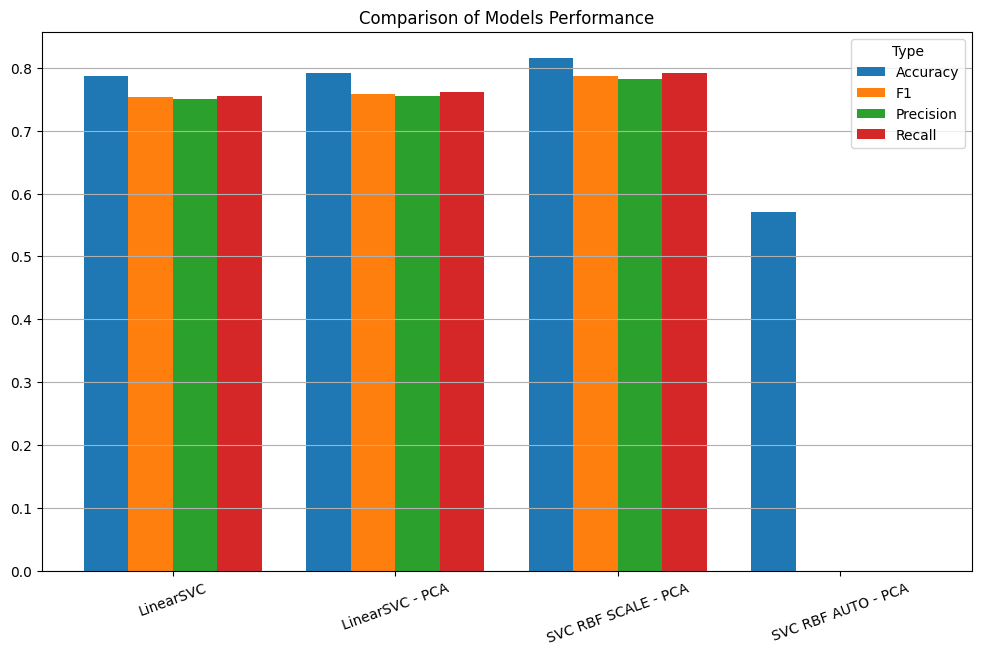

In [54]:
accuracy = [test_accuracy, test_accuracy_7_2, test_accuracy_7_3, test_accuracy_8]
f1 = [test_f1, test_f1_7_2, test_f1_7_3, test_f1_8]
precision = [test_precision, test_precision_7_2, test_precision_7_3, test_precision_8]
recall = [test_recall, test_recall_7_2, test_recall_7_3, test_recall_8]
models = ["LinearSVC", "LinearSVC - PCA", "SVC RBF SCALE - PCA", "SVC RBF AUTO - PCA"]

x = np.arange(len(models))
width = 0.2
plt.figure(figsize=(12, 7))

plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5*width, f1, width, label='F1')
plt.bar(x + 0.5*width, precision, width, label='Precision')
plt.bar(x + 1.5*width, recall, width, label='Recall')

plt.xticks(x, models, rotation=20)
#plt.ylabel('Score')
plt.title('Comparison of Models Performance')
plt.legend(title='Type')
plt.grid(axis='y')
#plt.tight_layout()
plt.show()

#Question 9

#9.1 Create a Gaussion Naive Bayes Model

In [55]:
model_9 = GaussianNB()

#9.2 Train Model on Training Set


In [56]:
x_train_tf_idf = x_train_tf_idf.toarray()
x_test_tf_idf = x_test_tf_idf.toarray()


In [59]:
model_9.fit(x_train_tf_idf, y_train)

GaussianNB()

#9.3 Evaluate Model on Train Set


In [60]:
y_pred_train_9 = model_9.predict(x_train_tf_idf)
train_accuracy_9 = accuracy_score(y_train, y_pred_train_9)
train_f1_9 = f1_score(y_train, y_pred_train_9)
train_precision_9 = precision_score(y_train, y_pred_train_9)
train_recall_9 = recall_score(y_train, y_pred_train_9)

print("== TRAIN SET METRICS ==")
print(f'Accuracy: {round(train_accuracy_9*100, 3)}%')
print(f'F1: {round(train_f1_9*100, 3)}%')
print(f'Precision: {round(train_precision_9*100, 3)}%')
print(f'Recall: {round(train_recall_9*100, 3)}%')

== TRAIN SET METRICS ==
Accuracy: 87.87%
F1: 87.632%
Precision: 77.987%
Recall: 100.0%


#9.4 Evaluate Model on Test Set


In [61]:
y_pred_test_9 = model_9.predict(x_test_tf_idf)
test_accuracy_9 = accuracy_score(y_test, y_pred_test_9)
test_f1_9 = f1_score(y_test, y_pred_test_9)
test_precision_9 = precision_score(y_test, y_pred_test_9)
test_recall_9 = recall_score(y_test, y_pred_test_9)

print("== TEST SET METRICS ==")
print(f'Accuracy: {round(test_accuracy_9*100, 3)}%')
print(f'F1: {round(test_f1_9*100, 3)}%')
print(f'Precision: {round(test_precision_9*100, 3)}%')
print(f'Recall: {round(test_recall_9*100, 3)}%')

== TEST SET METRICS ==
Accuracy: 61.417%
F1: 64.059%
Precision: 53.36%
Recall: 80.122%


Το μοντέλο αυτό αν και παρουσιάζει χαμηλότερη απόδοση σε σύγκριση με τα προηγούμενα, λόγω της υπόθεσης της ανεξαρτησίας των χαρακτηριστικών και της κανονικής κατανομής, έχει καλύτερο recall.